In [1]:
import re

import numpy as np

from matplotlib import pyplot as plt
from IPython.display import display, Markdown
from pathlib import Path
from collections import defaultdict

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400

def show():
    plt.savefig(f"{show.fig_counter}.pdf", dpi='figure', transparent=True, bbox_inches='tight')
    show.fig_counter += 1
    show.plt_show()

show.fig_counter = 0
show.plt_show = plt.show

plt.show = show

In [3]:
CC_PATTERN = re.compile(r"(?<!^)(?=[A-Z])")

In [4]:
BIODIVERSITY_PATTERN = re.compile(r"The simulation resulted in a biodiversity of (\d+) unique species\.")
EXECUTION_PATTERN = re.compile(r"The simulation took:\n - initialisation: ([^\n]+)\n - execution: ([^\n]+)\n - cleanup: ([^\n]+)\n")

In [5]:
TIME_PATTERN = re.compile(r"(\d+(?:\.\d+)?)([^\d]+)")
TIME_UNITS = {
    "ns": 0.000000001,
    "µs": 0.000001,
    "ms": 0.001,
    "s": 1.0,
}

def parse_time(time_str):
    match = TIME_PATTERN.match(time_str)
    
    if match is None:
        return None
    
    return float(match.group(1)) * TIME_UNITS[match.group(2)]

In [6]:
SPECIATION_FILE_PATTERN = re.compile(r"pbs\.([+\-]?(?:0|[1-9]\d*)(?:\.\d*)?(?:[eE][+\-]?\d+)?)\.o\d+\.\d+")

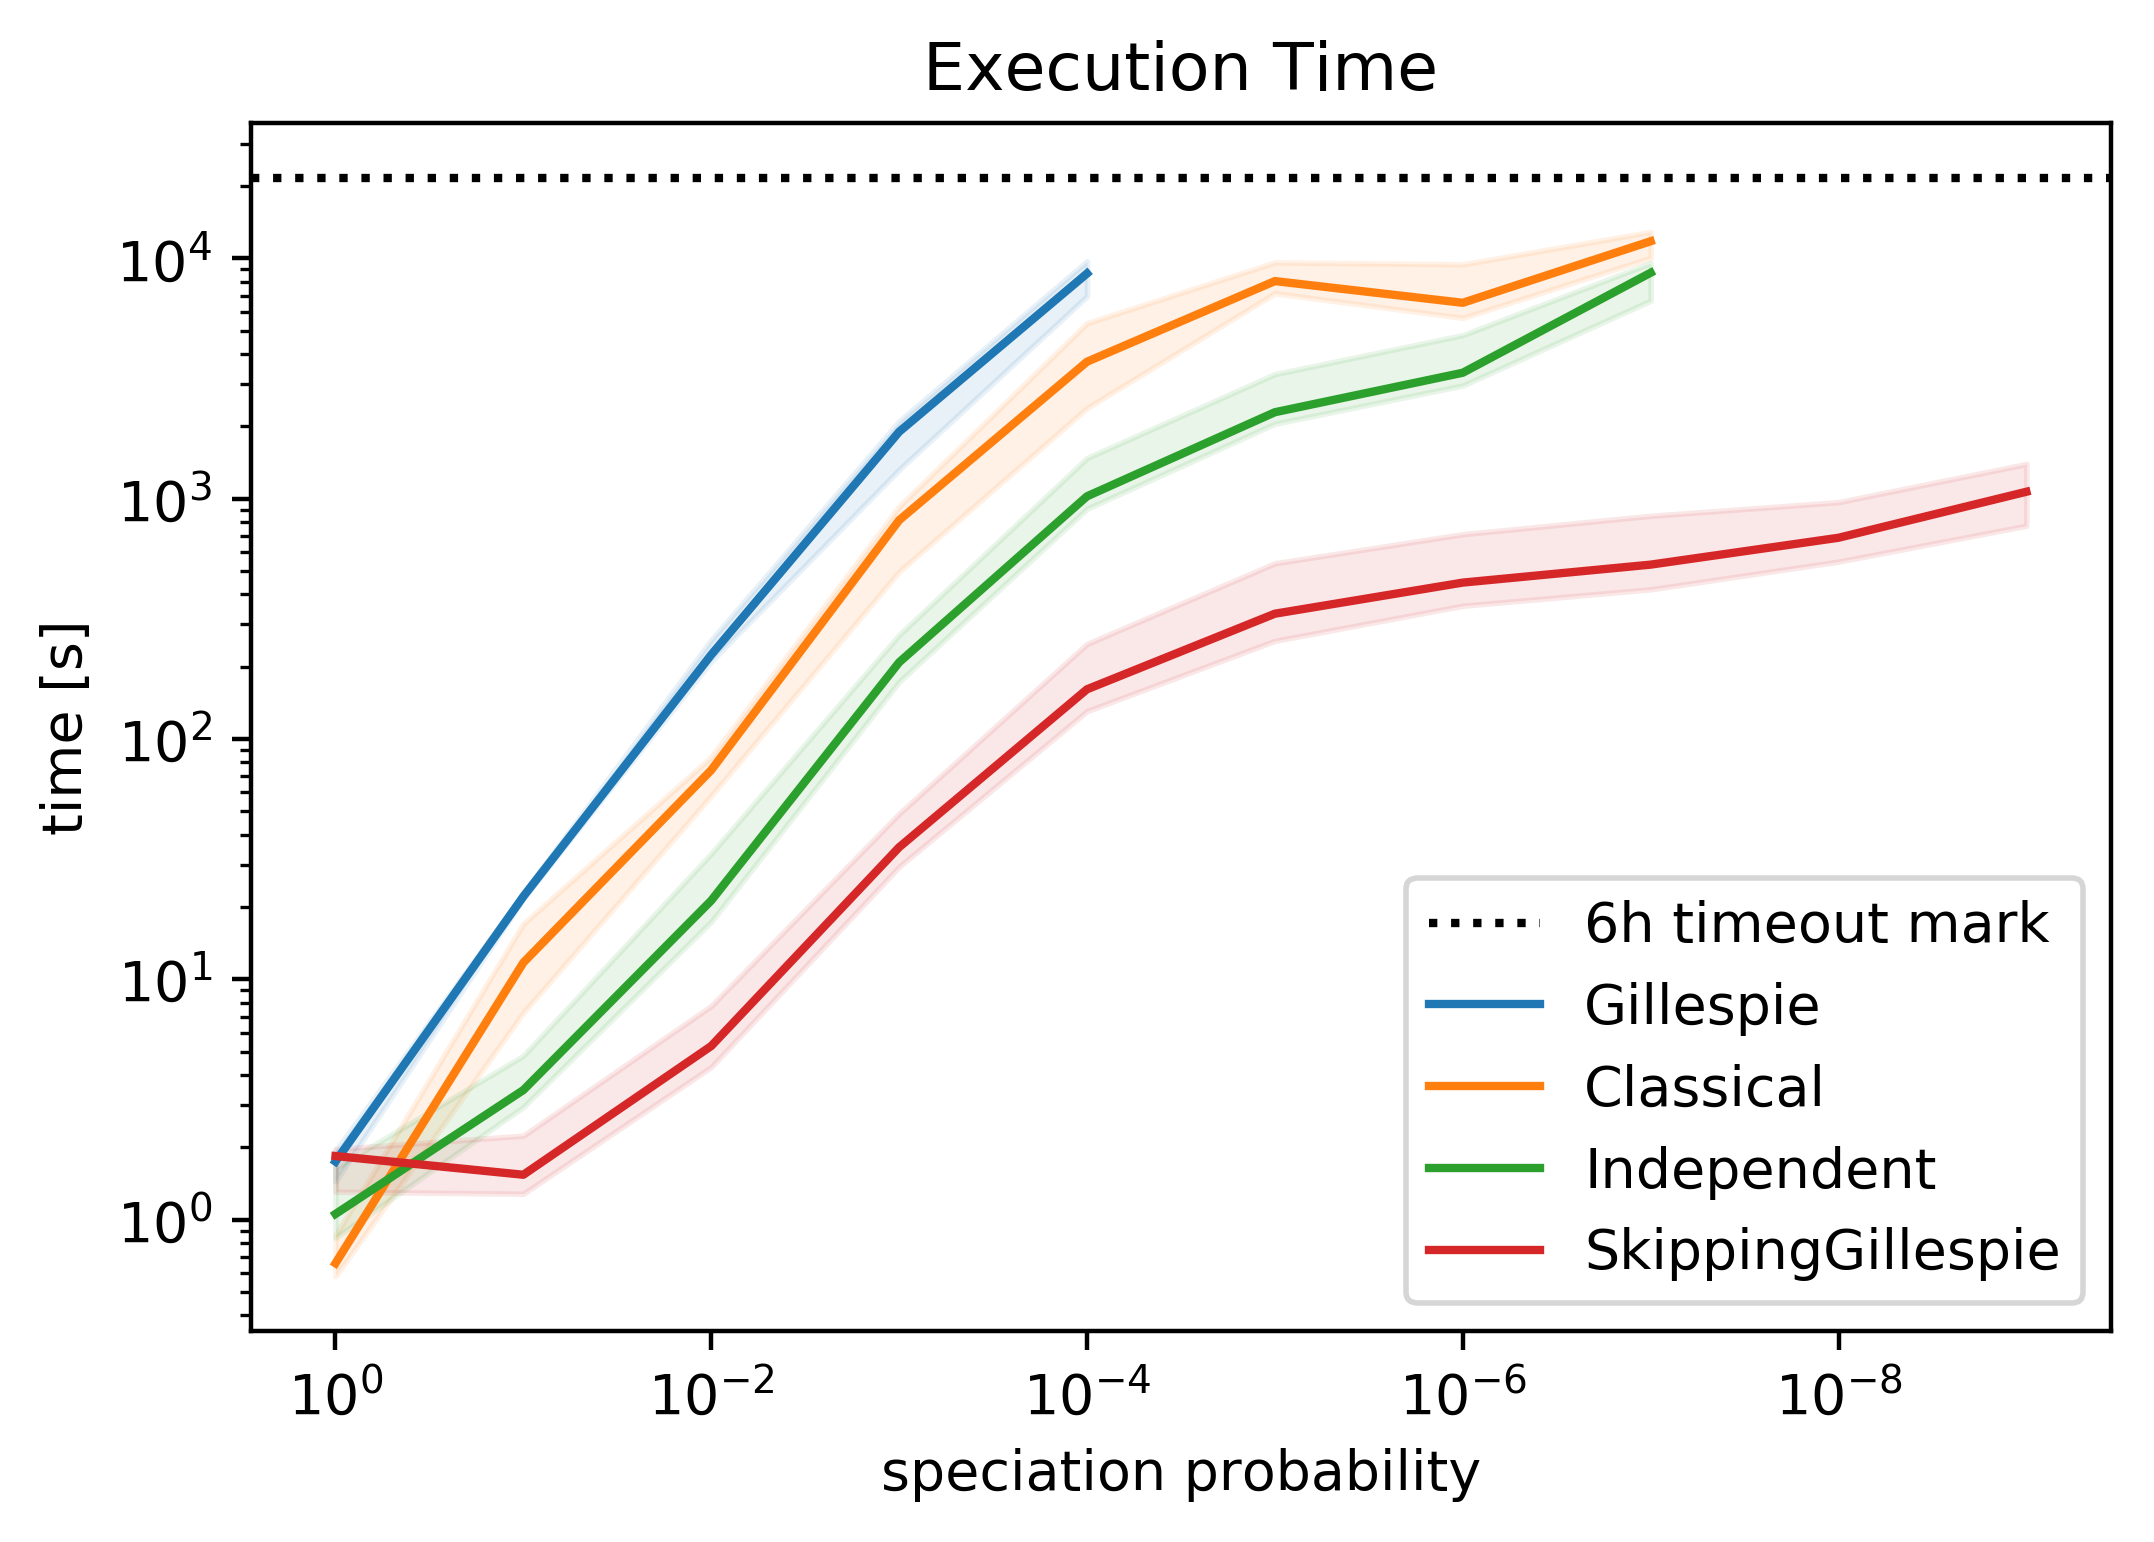

In [7]:
plt.title("Execution Time")
plt.xlabel("speciation probability")
plt.ylabel("time [s]")
plt.xscale("log")
plt.yscale("log")
plt.gca().invert_xaxis()

plt.axhline(y=6*60*60, color='black', linestyle=':', label="6h timeout mark")

for algorithm in ["Gillespie", "Classical", "Independent", "SkippingGillespie"]:
    results = defaultdict(list)

    for path in Path(CC_PATTERN.sub('-', algorithm).lower()).iterdir():
        match = SPECIATION_FILE_PATTERN.match(path.name)

        if match is None:
            continue

        speciation = float(match.group(1))

        with open(path) as file:
            stdout = file.read()

        match = BIODIVERSITY_PATTERN.search(stdout)
        if match is None:
            continue
        biodiversity = int(match.group(1))

        match = EXECUTION_PATTERN.search(stdout)
        if match is None:
            continue
        initialisation = parse_time(match.group(1))
        execution = parse_time(match.group(2))
        cleanup = parse_time(match.group(3))

        results[speciation].append((biodiversity, initialisation, execution, cleanup))

    results = { speciation: [(np.median(s), np.mean(s), np.std(s)) for s in zip(*result)] for speciation, result in results.items() }

    speciations, biodiversities, initialisations, executions, cleanups = zip(*sorted([speciation] + rs for speciation, rs in results.items()))

    plt.plot(speciations, np.array(executions)[:,0], label=algorithm)
    plt.fill_between(
        speciations,
        np.array(executions)[:,1] - np.array(executions)[:,2],
        np.array(executions)[:,1] + np.array(executions)[:,2],
        color=plt.gca().lines[-1].get_color(), alpha=0.1
    )

plt.legend()
plt.show()